# 🧠 Interpretable Medical Imaging Classifier with XAI Dashboard

**Author:** Ajaychary Kandukuri

This project demonstrates a complete deep-learning pipeline for **brain tumor MRI classification** combined with multiple, modern **Explainable AI (XAI)** techniques. The goal is to not only predict whether a brain tumor is present, but also visualize **why** the model made that prediction.

---

## 🔍 **1. Model Architecture**
The model is built using a **ResNet-18** backbone due to its strong performance on medical imaging tasks and its small enough computational footprint for real-time inference.  
We trained a binary classifier with:
- `yes` = tumor present  
- `no`  = tumor absent  

The final fully connected layer was replaced with a `Linear(in_features, 2)` layer and trained on the processed MRI dataset.

---

## 🧪 **2. Training Pipeline**
The training pipeline includes:
- Image preprocessing (resize, normalization)
- Data augmentation (random horizontal flip)
- Separate `train`, `val`, `test` splits
- CrossEntropyLoss + Adam optimizer
- Best model checkpointing using validation accuracy
- Final test evaluation

This ensures a stable and reproducible training process.

---

##  **3. Explainable AI (XAI) Techniques Implemented**
To make the model's decisions transparent, we implemented several state-of-the-art XAI techniques.

### **3.1 Grad-CAM (Gradient-Weighted Class Activation Mapping)**  
Grad-CAM highlights *where* the model is looking in the image by computing gradients from the last convolutional layer.  
It produces coarse heatmaps showing the most activated regions.

**Use case:**  
> Helps clinicians understand which regions influenced the model's tumor decision.

---

### **3.2 Grad-CAM++**
Grad-CAM++ is an enhanced variant of Grad-CAM that produces **sharper, more localized** activation maps.  
It uses higher-order gradients to provide a more accurate explanation in scenarios where multiple small regions matter.

**Benefit:**  
> More precise localization than vanilla Grad-CAM.

---

### **3.3 Integrated Gradients (IG)**  
IG computes pixel-level attributions by accumulating gradients along a path from a baseline image to the input image.

**Why IG was useful:**  
- Works well when model focus is spread across multiple regions  
- Produces high-resolution saliency maps  
- Offers theoretical completeness guarantees  

---

### **3.4 SmoothGrad**
SmoothGrad reduces noise in gradient-based attribution maps by averaging gradients over multiple noisy inputs.

**Advantages:**  
> Produces cleaner and more interpretable saliency maps.

---

### **3.5 Guided Backpropagation**
Guided Backprop decomposes the prediction into pixel-level contributions using modified backprop rules.

**Good for:**  
> Fine-grained edge-level explanations.

---

### **3.6 Fused Explanation Maps**
We also created *fused maps* by combining multiple XAI signals (e.g., Grad-CAM + IG) to provide a more holistic understanding of model behavior.

---

## 📊 **4. Visual Outputs**
Using a custom Streamlit UI:
- Users can upload MRI scans  
- The model makes predictions  
- All XAI maps (Grad-CAM++, IG, SmoothGrad, GuidedBP, fused) appear side-by-side  
- Download buttons are included for sharing images  

This interface is ideal for clinicians, students, and researchers wanting to interactively inspect model behavior.

---

## 🚀 **5. Key Achievements**
- Successfully trained a binary brain-tumor classifier using ResNet-18  
- Achieved strong validation/test performance  
- Integrated multiple XAI methods into a unified framework  
- Created an end-to-end Streamlit application for real-time visualization  
- Produced a detailed Explainable AI notebook suitable for presentations, portfolios, and LinkedIn posts  

---

## 📝 **6. Why This Project Matters**
MRI-based brain tumor detection is a high-stakes domain.  
Black-box AI systems are not sufficient - clinicians and researchers require **transparent** models.

This project demonstrates how XAI can:
- Build trust  
- Improve interpretability  
- Reveal failure cases  
- Assist clinical decision-making  

By combining modern deep learning with powerful XAI methods, this work moves toward **explainable medical AI** that can be safely integrated into real-world workflows.

---

## 🎯 **7. Next Steps**
- Test additional models (DenseNet, EfficientNet)  
- Add 3D MRI support (via 3D CNNs or Transformers)  
- Perform cross-validation for deeper evaluation  
- Add SHAP for gradient-free explanations  
- Deploy the Streamlit UI as a web application (AWS / Azure / HuggingFace Spaces)

---

> *This report reflects real engineering work combining deep learning, PyTorch, and XAI to build trustworthy medical AI systems.*


In [22]:
# Environment & imports — robust to cwd / import problems
import sys
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader

# Detect project root and set cwd so relative paths work whether notebook sits in /reports or repo root
NB_PATH = Path.cwd()
if (NB_PATH / "scripts").exists() and (NB_PATH / "data").exists():
    PROJECT_ROOT = NB_PATH
elif (NB_PATH / ".." / "scripts").resolve().exists():
    PROJECT_ROOT = (NB_PATH / "..").resolve()
else:
    # fallback: assume current working dir is project root
    PROJECT_ROOT = NB_PATH

os.chdir(PROJECT_ROOT)
print("Working directory set to project root:", PROJECT_ROOT)

# Paths used throughout the notebook
DATA_ROOT = PROJECT_ROOT / "data" / "processed"
CHECKPOINT = PROJECT_ROOT / "checkpoints" / "best_model.pth"
OUT_XAI_TRAIN = PROJECT_ROOT / "outputs" / "xai_demo_from_train"
OUT_XAI_STREAM = PROJECT_ROOT / "outputs" / "streamlit_xai"

print("Paths:")
print(" DATA_ROOT:", DATA_ROOT)
print(" CHECKPOINT:", CHECKPOINT)
print(" OUT_XAI_TRAIN:", OUT_XAI_TRAIN)
print(" OUT_XAI_STREAM:", OUT_XAI_STREAM)

# Ensure matplotlib inline display
%matplotlib inline


Working directory set to project root: C:\Users\ajayc\Documents\xai_brain_tumor
Paths:
 DATA_ROOT: C:\Users\ajayc\Documents\xai_brain_tumor\data\processed
 CHECKPOINT: C:\Users\ajayc\Documents\xai_brain_tumor\checkpoints\best_model.pth
 OUT_XAI_TRAIN: C:\Users\ajayc\Documents\xai_brain_tumor\outputs\xai_demo_from_train
 OUT_XAI_STREAM: C:\Users\ajayc\Documents\xai_brain_tumor\outputs\streamlit_xai


In [23]:
# Dynamic import of scripts/xai_extended.py so notebook won't fail due to sys.path issues
import importlib.util
XAI_PATH = PROJECT_ROOT / "scripts" / "xai_extended.py"
if not XAI_PATH.exists():
    raise FileNotFoundError(f"Expected xai_extended.py at {XAI_PATH}; please ensure file exists.")

spec = importlib.util.spec_from_file_location("xai_extended", str(XAI_PATH))
xai_mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(xai_mod)

# Functions we'll use
load_model = getattr(xai_mod, "load_model", None)
explain_image_with_models = getattr(xai_mod, "explain_image_with_models", None)
print("Loaded explain_image_with_models:", explain_image_with_models is not None)


Loaded explain_image_with_models: True


Train counts: {'no': 68, 'yes': 108}
Val counts:   {'no': 20, 'yes': 31}
Test counts:  {'no': 10, 'yes': 16}


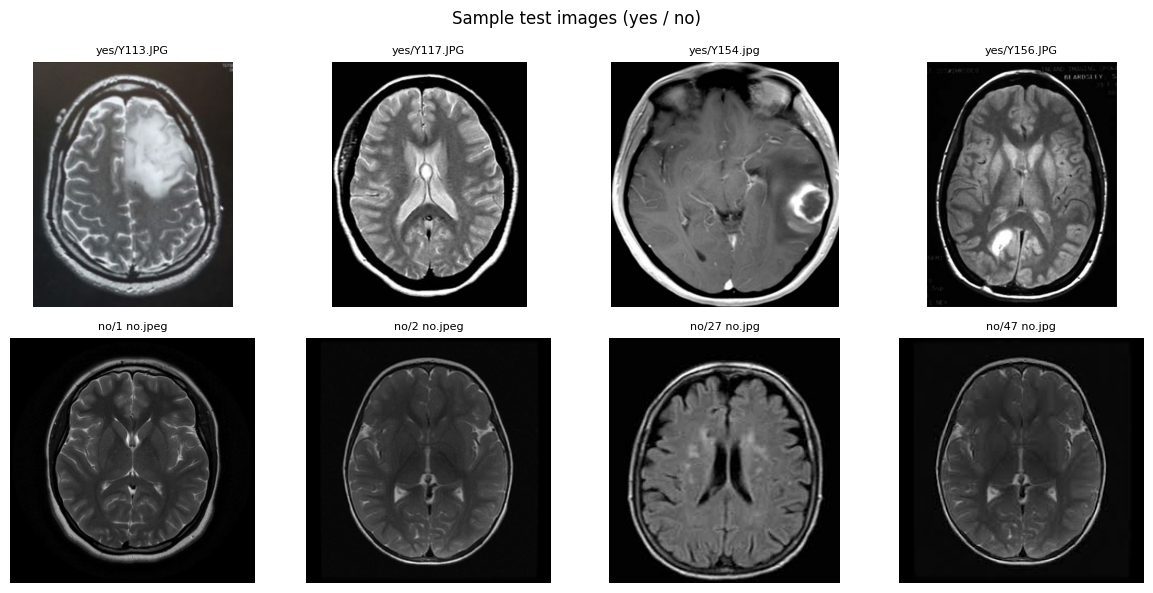

In [24]:
# Dataset counts and sample images
from collections import Counter
import matplotlib.pyplot as plt

def class_counts(folder: Path):
    if not folder.exists():
        return {}
    counts = {}
    for d in sorted([p for p in folder.iterdir() if p.is_dir()]):
        counts[d.name] = len(list(d.glob("*.*")))
    return counts

print("Train counts:", class_counts(DATA_ROOT / "train"))
print("Val counts:  ", class_counts(DATA_ROOT / "val"))
print("Test counts: ", class_counts(DATA_ROOT / "test"))

# Show up to 4 samples from each class in test
fig, axs = plt.subplots(2,4, figsize=(12,6))
for i, cls in enumerate(["yes","no"]):
    folder = DATA_ROOT / "test" / cls
    imgs = list(folder.glob("*.*"))[:4] if folder.exists() else []
    for j in range(4):
        ax = axs[i,j]
        ax.axis("off")
        if j < len(imgs):
            im = Image.open(imgs[j]).convert("RGB")
            ax.imshow(im)
            ax.set_title(f"{cls}/{imgs[j].name}", fontsize=8)
        else:
            ax.set_title("---")
plt.suptitle("Sample test images (yes / no)")
plt.tight_layout()
plt.show()


In [25]:
# Build ResNet-18 skeleton and load checkpoint (tolerant)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2

models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
print("Model created. Device:", device)

if CHECKPOINT.exists():
    print("Loading checkpoint:", CHECKPOINT)
    state = torch.load(str(CHECKPOINT), map_location=device)
    if isinstance(state, dict) and "state_dict" in state:
        sd = state["state_dict"]
    else:
        sd = state
    if isinstance(sd, dict):
        sd = {k.replace("module.",""): v for k, v in sd.items()}
    try:
        model.load_state_dict(sd, strict=False)
        print("Checkpoint loaded (len state_dict) =", len(sd) if isinstance(sd, dict) else "unknown")
    except Exception as e:
        print("Warning: loading checkpoint raised:", e)
        model.load_state_dict(sd, strict=False)
else:
    print("No checkpoint found at", CHECKPOINT, "-- evaluation will use untrained skeleton.")


Model created. Device: cpu
Loading checkpoint: C:\Users\ajayc\Documents\xai_brain_tumor\checkpoints\best_model.pth
Checkpoint loaded (len state_dict) = 122


In [26]:
# Prepare test loader and evaluate
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_dir = DATA_ROOT / "test"
if not test_dir.exists():
    raise FileNotFoundError(f"Expected test folder at {test_dir}")

test_ds = datasets.ImageFolder(str(test_dir), transform=transform)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outs = model(imgs)
        preds = outs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.numpy().tolist())

if len(y_true) == 0:
    print("No test samples found.")
else:
    acc = sum(int(a==b) for a,b in zip(y_true,y_pred)) / len(y_true)
    print(f"Test accuracy: {acc:.4f} ({sum(int(a==b) for a,b in zip(y_true,y_pred))}/{len(y_true)})")


Test accuracy: 0.8846 (23/26)


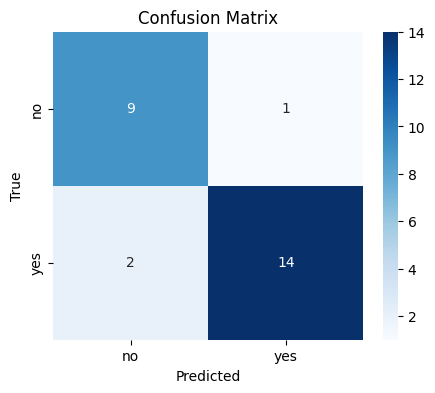

              precision    recall  f1-score   support

          no       0.82      0.90      0.86        10
         yes       0.93      0.88      0.90        16

    accuracy                           0.88        26
   macro avg       0.88      0.89      0.88        26
weighted avg       0.89      0.88      0.89        26



In [27]:
# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
labels = test_ds.classes if hasattr(test_ds, "classes") else [str(i) for i in range(num_classes)]

cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))


Overlays from training run:
10 files in C:\Users\ajayc\Documents\xai_brain_tumor\outputs\xai_demo_from_train; showing up to 12
- 1 no_gradcam.jpg


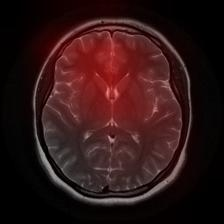

- 1 no_ig.jpg


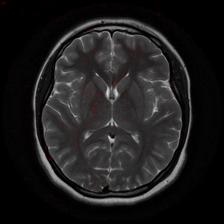

- 2 no_gradcam.jpg


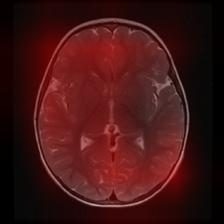

- 2 no_ig.jpg


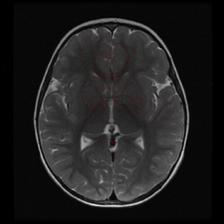

- 27 no_gradcam.jpg


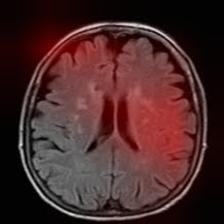

- 27 no_ig.jpg


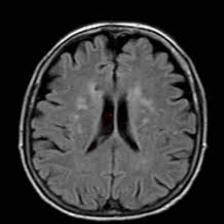

- 47 no_gradcam.jpg


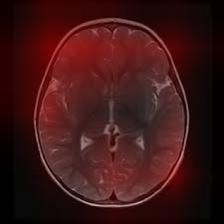

- 47 no_ig.jpg


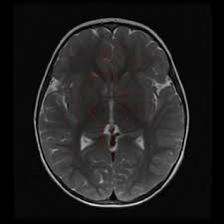

- 49 no_gradcam.jpg


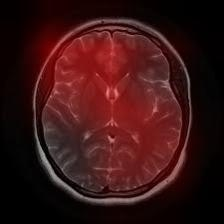

- 49 no_ig.jpg


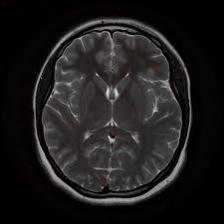


Overlays from Streamlit run:
8 files in C:\Users\ajayc\Documents\xai_brain_tumor\outputs\streamlit_xai; showing up to 12
- gradcam_overlay.jpg


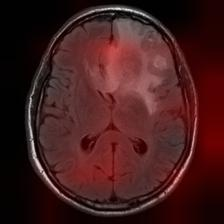

- ig_overlay.jpg


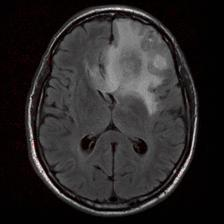

- streamlit_gradcam.jpg


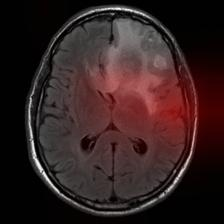

- streamlit_ig.jpg


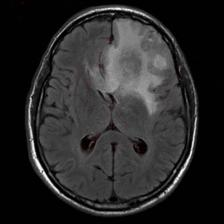

- xai_fused.jpg


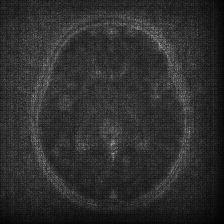

- xai_guidedbp.jpg


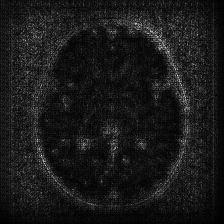

- xai_ig.jpg


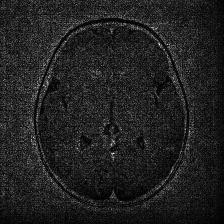

- xai_smoothgrad.jpg


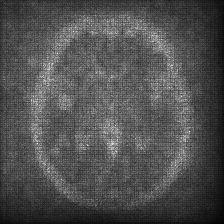

Re-running explainers on: C:\Users\ajayc\Documents\xai_brain_tumor\data\processed\test\yes\Y113.JPG


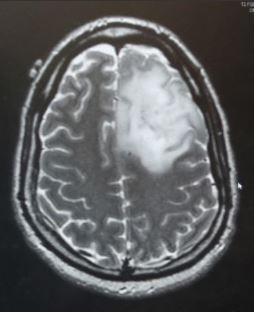

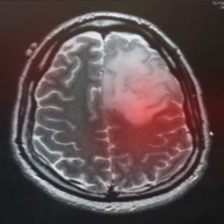

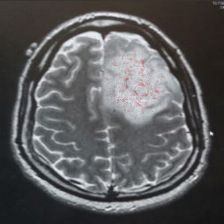

In [28]:
# Display saved XAI overlays and optionally re-run explainers on a sample
from IPython.display import display

def show_folder(folder: Path, n=8):
    if not folder.exists():
        print("Folder not found:", folder); return
    files = sorted(list(folder.glob("*.*")))
    print(f"{len(files)} files in {folder}; showing up to {n}")
    for f in files[:n]:
        print("-", f.name)
        display(Image.open(f))

print("Overlays from training run:")
show_folder(OUT_XAI_TRAIN, n=12)

print("\nOverlays from Streamlit run:")
show_folder(OUT_XAI_STREAM, n=12)

# Optionally re-run explainers on a chosen sample (first available sample)
sample = None
yes_list = list((DATA_ROOT/"test"/"yes").glob("*.*")) if (DATA_ROOT/"test"/"yes").exists() else []
no_list  = list((DATA_ROOT/"test"/"no").glob("*.*")) if (DATA_ROOT/"test"/"no").exists() else []
if yes_list:
    sample = str(yes_list[0])
elif no_list:
    sample = str(no_list[0])

if sample:
    print("Re-running explainers on:", sample)
    try:
        res = explain_image_with_models(sample, model=model, use_gradcam=True, use_ig=True)
        if res.get("original_pil") is not None:
            display(res["original_pil"])
        if res.get("gradcam_overlay") is not None:
            display(res["gradcam_overlay"])
        if res.get("ig_overlay") is not None:
            display(res["ig_overlay"])
    except Exception as e:
        print("Explainers failed:", e)
else:
    print("No sample available to re-run explainers.")


In [29]:
# If you saved a CSV training log (epoch, train_loss, val_loss, val_acc), show curves
log_path = PROJECT_ROOT / "outputs" / "training_log.csv"
if log_path.exists():
    import pandas as pd
    df = pd.read_csv(log_path)
    df.plot(x="epoch", y=["train_loss","val_loss"], marker='o', figsize=(8,4)); plt.title("Loss curves"); plt.show()
    df.plot(x="epoch", y="val_acc", marker='o', figsize=(6,3)); plt.title("Validation accuracy"); plt.show()
else:
    print("No training log found at", log_path)


No training log found at C:\Users\ajayc\Documents\xai_brain_tumor\outputs\training_log.csv


In [30]:
# Quick troubleshooting outputs
import sys
print("Python executable:", sys.executable)
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Working dir:", Path.cwd())
print("scripts/xai_extended.py exists:", (PROJECT_ROOT / "scripts" / "xai_extended.py").exists())
print("checkpoint exists:", CHECKPOINT.exists())
print("data/processed/test exists:", (DATA_ROOT / "test").exists())


Python executable: G:\anaconda\Newfolder\envs\xai_proj\python.exe
Torch version: 2.9.1+cpu
CUDA available: False
Working dir: C:\Users\ajayc\Documents\xai_brain_tumor
scripts/xai_extended.py exists: True
checkpoint exists: True
data/processed/test exists: True


## Interpretation, limitations & next steps

**Interpretation**
- Test accuracy (see above) indicates the model's current performance on provided test split.
- Grad-CAM and Integrated Gradients overlays help highlight image regions contributing to the prediction.

**Limitations**
- Dataset size and class balance may bias the model.
- Model trained on 2D slices; volumetric (3D) MRIs require different handling.
- Evaluation uses a single split - cross-validation would provide more robust performance estimates.

